In [1]:
from rubia_cnn import *
from stridednet import *

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

classes = np.unique(y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train X shape:', X_train.shape)
print('Train y shape:', y_train.shape)

width, height, depth = 28, 28, 1
print('Classes:', classes)

Train X shape: (60000, 28, 28, 1)
Train y shape: (60000, 10)
Classes: [0 1 2 3 4 5 6 7 8 9]


## Testes
Para testar o uso da GPU e dos núcleos da CPU:
* abrir em outra janela um terminal e executar
    `watch -n 0.1 nvidia-smi`
    * observar o % em Volatile na parte de cima e a lista de processes na parte de baixo
* abrir em outra janela um terminal e executar
    `top`
    * observar a coluna %CPU e a coluna COMANDO
* deixar o notebook rodando lado a lado e ir acompanhando o desempenho da CPU e GPU
    
### Reiniciar o Kernel após alterar o setup GPU/CPU
Executar as células abaixo e acompanhar estes 2 relatórios. 
* Se a GPU foi ativada corretamente vai aparecer uma nova linha nos processos e o % Volatile vai subir
    * as vezes não usa toda a capacidade
* Se múltiplos núcleos da CPU foram ativados o %CPU vai ultrapassar 100, em múltiplos (200, 300, 500, 700, 1000)
    * as vezes não usa toda a capacidade

In [3]:
gpu = False # alterar, reiniciar o kernel e testar novamente
workers = 10 # alterar, reiniciar o kernel e testar novamente, esse valor pode ser negativo (-2 é todos -2)
epochs = 20 # se quiser deixar mais tempo rodando, só aumentar aqui
batch_size = 256 # ir aumentando o tamanho de batch até dar erro de falta de memória, o %Volatile vai ir subindo

k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Number of workers adjusted to fit the GPUs available
Using 1 GPU workers
CPU test for EYE(10000):  0.273867130279541
GPU test for EYE(10000):  0.30759644508361816
Multiprocessing status: False

Neural network setup:
X data shape:             (60000, 28, 28, 1)
y data shape:             (60000, 10)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          1

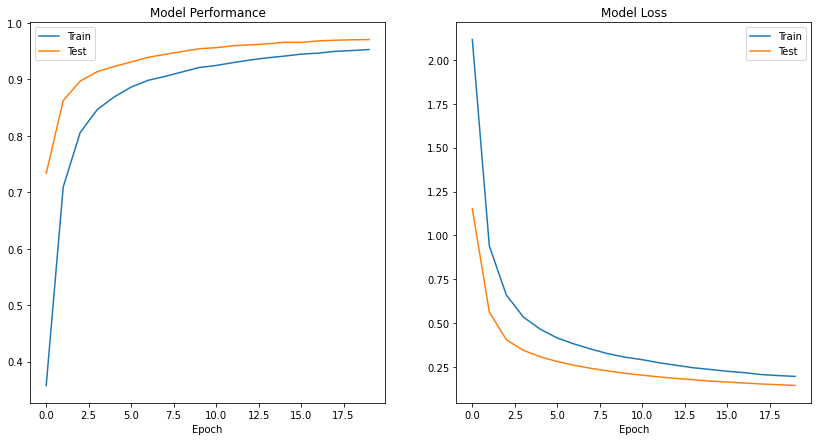


Model evaluation


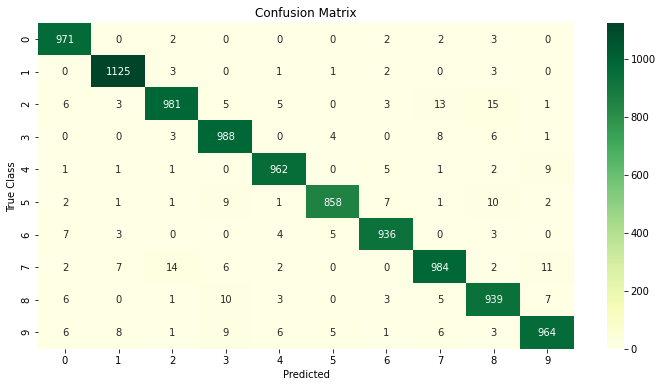

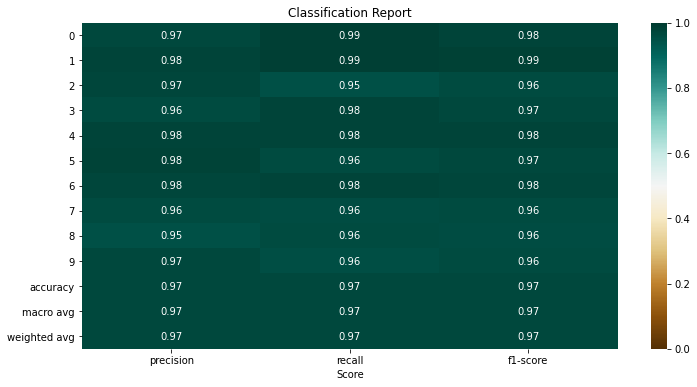

ACCURACY:  97.1 %
Total elapsed time (epochs per second): 24.8 seg (0.81)


In [4]:
opt = Adam(lr=1e-4, decay=1e-4/epochs)
reg = l2(0.0005)

model = StridedNetOne.build(width=width, height=height, depth=depth, 
                            classes=len(classes), reg=reg)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

start = time.time()
print('\nTraining started: using ClassOne')
history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)

print('Total elapsed time (epochs per second): %.1f seg (%.2f)' % (time.time()-start, epochs / (time.time()-start)))